<a href="https://colab.research.google.com/github/tudor-berariu/ann2018/blob/master/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders
## 1. Miscellaneous

In [0]:
# Install PyTorch 0.4.1 with CUDA support

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
#@title Test PyTorch with CUDA

import torch
from torch import Tensor
assert torch.cuda.is_available()

In [0]:
import matplotlib.pyplot as plt
from math import ceil

def show_images(X: torch.Tensor, nrows=3):
  ncols = int(ceil(len(X) / nrows))
  ratio = nrows / ncols
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10 * ratio))
  for idx, img in enumerate(X):
    r, c = idx // ncols, idx % ncols
    axs[r][c].imshow(img[0].numpy(), aspect='equal', vmin=0, vmax=1)
    
  for row_axs in axs:
    for ax in row_axs:
      ax.set_aspect('equal', 'box')
      ax.set_yticklabels([])
      ax.set_xticklabels([])
  fig.tight_layout()

## 2. Our dataset

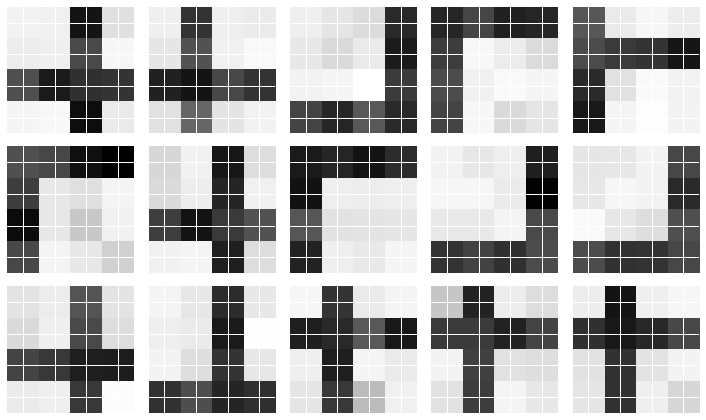

In [4]:
def get_dataset(n, idxs):
  X = torch.randn(n * 16) * .1
  X[idxs] += 1
  X = (X - X.min()) / (X.max() - X.min())
  X.clamp_(0, 1)
  X = X.reshape(n, 1, 4, 4)
  return X


n = 15
idxs = [2, 6, 8, 9, 10, 11, 14, 17, 21, 24, 25, 26, 27, 29, 35, 39, 43, 44, 45,
        46, 47, 48, 49, 50, 51, 52, 56, 60, 64, 68, 69, 70, 71, 72, 76, 80, 81,
        82, 83, 84, 88, 92, 98, 102, 104, 105, 106, 107, 110, 112, 113, 114,
        115, 116, 120, 124, 131, 135, 139, 140, 141, 142, 143, 147, 151, 155,
        156, 157, 158, 159, 162, 166, 168, 169, 170, 171, 174, 178, 182, 186,
        188, 189, 190, 191, 193, 196, 197, 198, 199, 201, 205, 209, 212, 213,
        214, 215, 217, 221, 225, 228, 229, 230, 231, 233, 237]



X = get_dataset(n, idxs)
show_images(X)

## 3. The Variational Auto-encoder


The encoder computes $q_{\phi}\left(z \mid x\right)$ predicting:

 - $\mu_{\phi}\left(x\right)$ and
 - $\log \sigma_{\phi}^2\left(x\right)$.
 
 
 The decoder computes $p_{\theta}\left(x \mid z\right)$.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
  
  def __init__(self, nz: int = 1) -> None:
    super(VAE, self).__init__()
    self.nz = nz  # The number of dimensions in the latent space
    self.encoder = nn.Sequential(nn.Linear(16, 64), nn.ReLU())
    self.mean = nn.Linear(64, nz)  # predicts the mean of p(z|x)
    self.log_var = nn.Linear(64, nz)  # predicts the log-variance of p(z|x)
    self.decoder = nn.Sequential(nn.Linear(nz, 64), nn.ReLU(),
                                 nn.Linear(64, 16))
    
  def forward(self, x):
    x = x.view(-1, 16)  # Drop this if you use convolutional encoders
    
    # Encoding x into mu, and log-var of p(z|x)
    x = self.encoder(x)
    mean = self.mean(x)
    log_var = self.log_var(x)
    
    # ----------------------------------------------------------------
    # TODO 1: compute z = (eps * std) + mean (reparametrization trick)
    noise = None
    # ----------------------------------------------------------------
    
    # Decoding z into p(x|z)
    x = self.decoder(noise)
    x = torch.sigmoid(x)
    
    return x.view(-1, 1, 4, 4), mean, log_var
  
  def generate(self, nsamples: int = None, noise: Tensor = None) -> Tensor:
    # Generate some data
    with torch.no_grad():
      if noise is None:
        noise = torch.randn(nsamples, self.nz)      
      x = self.decoder(noise)
      x = torch.sigmoid(x)
      return x.view(-1, 1, 4, 4)

## 4. Training the model

The optimization criterion has two components.

 - the KL divergence between $q_{\phi}\left(z \mid x\right)$ and $p\left(z\right)$
   * both are diagonal gaussians, therefore we have a simple formula for the KL divergence: [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Examples)
   
 - the reconstriction loss computed using the [binary cross entropy](https://pytorch.org/docs/stable/nn.html#binary-cross-entropy)
   

In [0]:
import torch.optim as optim
import numpy as np

def train(vae: VAE, X: torch.Tensor, nsteps: int = 200000):
  bce_trace, kl_trace = [], []
  optimizer = optim.Adam(vae.parameters(), lr=.001)
  
  for step in range(nsteps):
    optimizer.zero_grad()
    rec, mean, log_var = vae(X + torch.randn_like(X) * .05)
    
    # -----------------------------------------------
    # TODO 2: compute the two losses (do not average)
    bce = None
    kl = None
    # -----------------------------------------------
    
    (bce + kl).backward()
    optimizer.step()
    
    # Chestiuni pentru afișare
    bce_trace.append(bce.item())
    kl_trace.append(kl.item())
        
    if (step + 1) % 100 == 0:
      print(f"\rStep {step + 1:d}: BCE={np.mean(bce_trace):9.4f}"
            f"KL={np.mean(kl_trace):9.4f}", end="")
      bce_trace.clear()
      kl_trace.clear()
      if (step + 1) % 2500 == 0:
        print("")

In [7]:
vae = VAE()
train(vae, X)

AttributeError: ignored

## 5. Evaluating the model

### 5.1 Reconstructions

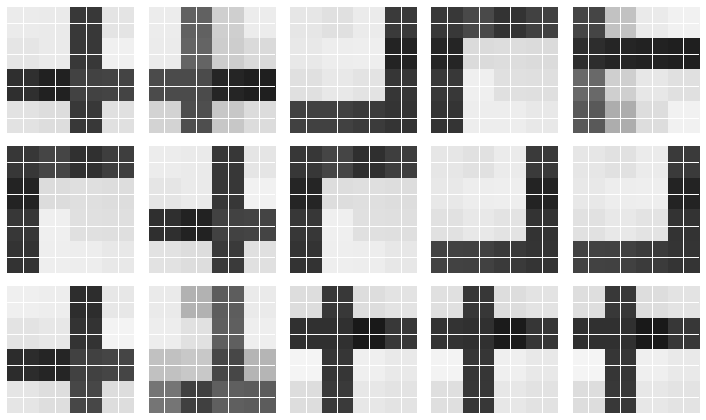

In [0]:
with torch.no_grad():
  recon, _, _ = vae(X)
  
show_images(recon)

### 5.2 Samples from the model

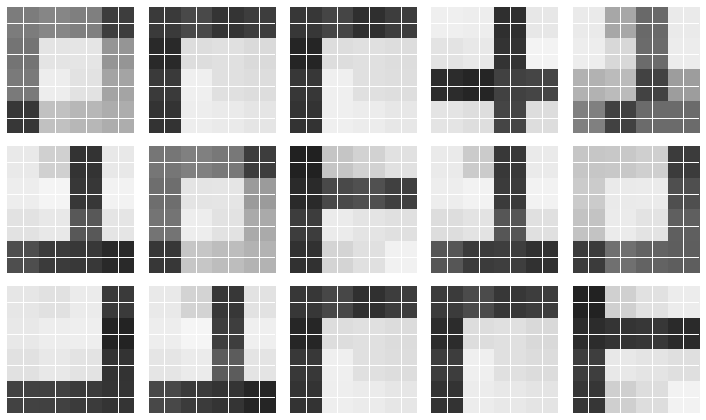

In [0]:
X_gen = vae.generate(nsamples=15)
show_images(X_gen)

### 5.3 Walk the latent space :)

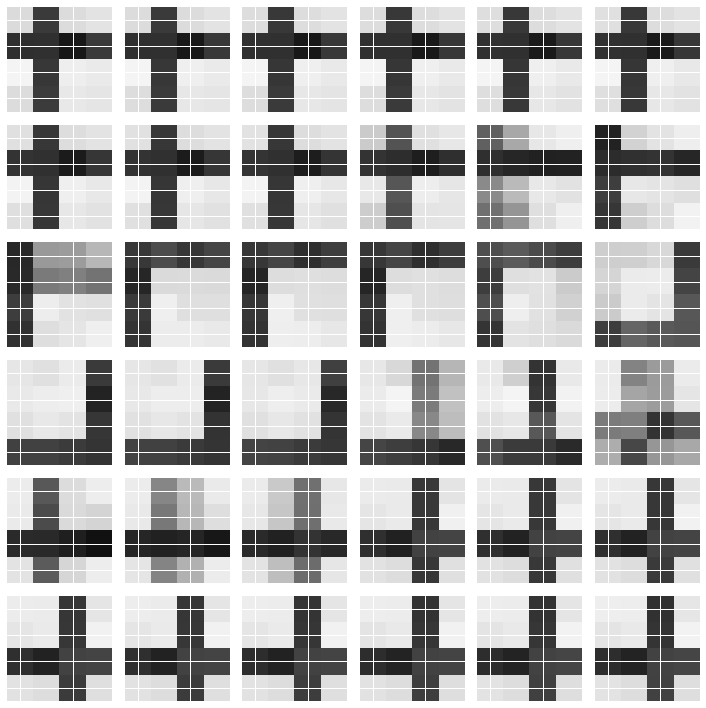

In [0]:
N = 36
noise = torch.linspace(-2, 2, N).unsqueeze(1)
X_gen = vae.generate(noise=noise)
show_images(X_gen, nrows=6)